<a href="https://colab.research.google.com/github/smnststn/Heart-disease/blob/main/Regresion_Heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

This project explores a simple experiment in predicting heart failure using supervised learning, specifically regression techniques. While heart failure is a serious condition requiring early detection, this analysis is more of a playful dive into the data rather than a groundbreaking medical tool. Using available data, we aim to build a basic predictive model and gain insights into which factors might indicate a higher risk of heart failure.

**Data:** *'heart.csv'*  ▶ the csv file should be downloaded automatically using the code in the notebook


**Source:** https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction


# **Setup**

In [208]:
!pip install ydata-profiling  # Install if necessary

In [209]:
!pip install lazypredict # Install if necessary

In [210]:
# Loading, preprocessing & analysis of data
import kagglehub
import pandas as pd
import numpy as np
import os

from ydata_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import GridSearchCV
from lazypredict.Supervised import LazyClassifier

# Metrics
from sklearn.metrics import recall_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve

# Visualization
import matplotlib.pyplot as plt

Herebelow are initial constants that function as toggle switches, allowing you to control whether specific actions should be executed. For example, you can choose to run Pandas Profiling, which generates a comprehensive exploratory analysis report in a separate window. This flexibility helps manage computational resources efficiently, enabling time-consuming processes only when necessary.

In [211]:
# Toggle switches to enable or disable specific actions

YData_report = False # allow analysis by Pandas Profiling

# Should we use only data sample (for faster modeling)?
Sample_data = False
Sample_size = 10000

# Select features based on correlation results?
Feature_selection = False
Correlation_threshold = 0.2 # Correlation threshold

**Loading data**

The dataset is available on Kaggle, and the following code loads it from a CSV file into a Pandas DataFrame, without having to download the file manually.

In [212]:
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

files = os.listdir(path)

# assuming there's only one file, get the first (and only) file name
csv_file = files[0]

csv_path = os.path.join(path, csv_file)
print("Path to csv file:", csv_path)
data = pd.read_csv(csv_path)

Path to csv file: /root/.cache/kagglehub/datasets/fedesoriano/heart-failure-prediction/versions/1/heart.csv


In [213]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


## **Analyzation of Data by Pandas Profiling**

In [214]:
# The comprehensive exploratory analysis report will be executed only if YData_report is set to True

if YData_report:
  profile = ProfileReport(data)
  profile.to_notebook_iframe()

# **Preprocessing**


In [215]:
print(f"At first glance it seems there are no missing values. \n\n{data.isna().sum()}")

At first glance it seems there are no missing values. 

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [216]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


However, after inspection of the above overview, especially the minimal values in our data, it becomes clear that there are zero values in the Cholesterol and RestingBP columns, which are clinically implausible. As a result, these zero values will be replaced with the mean of the non-zero values in the respective columns.

In [217]:
# Saving indexes of data where Cholesterol & RestingBP is zero

zero_cholesterol = data[data['Cholesterol'] == 0].index
zero_restingbp = data[data['RestingBP'] == 0].index

print(f"Number of samples with 0 Cholesterol: {len(zero_cholesterol)}")
print(f"Number of samples with 0 RestingBP: {len(zero_restingbp)}")

Number of samples with 0 Cholesterol: 172
Number of samples with 0 RestingBP: 1


In [218]:
# Imputing zero values for columns Cholesterol & RestingBP with mean values

mean_cholesterol = data[data['Cholesterol'] != 0]['Cholesterol'].mean()
mean_restingbp = data[data['RestingBP'] != 0]['RestingBP'].mean()

print(f"Mean Cholesterol (excluding 0s): {mean_cholesterol}")
print(f"Mean RestingBP (excluding 0s): {mean_restingbp}")

data["Cholesterol"] = data["Cholesterol"].apply(lambda x: mean_cholesterol if x == 0 else x)
data["RestingBP"] = data["RestingBP"].apply(lambda x: mean_restingbp if x == 0 else x)

Mean Cholesterol (excluding 0s): 244.6353887399464
Mean RestingBP (excluding 0s): 132.54089422028352


In [219]:
# Double-checking that zero values have been imputed correcly
data.iloc[zero_cholesterol]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115.00,244.64,0,Normal,93,Y,0.00,Flat,1
294,32,M,TA,95.00,244.64,1,Normal,127,N,0.70,Up,1
295,61,M,ASY,105.00,244.64,1,Normal,110,Y,1.50,Up,1
296,50,M,ASY,145.00,244.64,1,Normal,139,Y,0.70,Flat,1
297,57,M,ASY,110.00,244.64,1,ST,131,Y,1.40,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122.00,244.64,0,Normal,120,N,0.50,Up,1
515,63,M,NAP,130.00,244.64,1,ST,160,N,3.00,Flat,0
518,48,M,NAP,102.00,244.64,1,ST,110,Y,1.00,Down,1
535,56,M,ASY,130.00,244.64,0,LVH,122,Y,1.00,Flat,1


In [220]:
data.iloc[zero_restingbp]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,132.54,244.64,0,Normal,155,N,1.50,Flat,1


## Encoding of non-numerical data

The next step involves ensuring that all data is in numerical format. To achieve this, we begin by identifying variables of type "object," which correspond to categorical or text-based data. Based on the unique values in these columns, we will apply the appropriate encoding techniques to transform them into numerical representations suitable for analysis.

In [221]:
object_columns = data.select_dtypes(include=['object']).columns

for column in object_columns:
    print(f"Unique values in column {column}: {data[column].unique()}")

Unique values in column Sex: ['M' 'F']
Unique values in column ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
Unique values in column RestingECG: ['Normal' 'ST' 'LVH']
Unique values in column ExerciseAngina: ['N' 'Y']
Unique values in column ST_Slope: ['Up' 'Flat' 'Down']


### **Ordinal encoding**

For attributes like Sex (male or female) and ExerciseAngina (Yes or No), we apply binary encoding.

In [222]:
encoding_sex = {"M": 1, "F": 0}
data["Sex"] = data["Sex"].apply(lambda sex: encoding_sex[sex])

In [223]:
encoding_angina = {"Y": 1, "N": 0}
data["ExerciseAngina"] = data["ExerciseAngina"].apply(lambda angina: encoding_angina[angina])

The ST_Slope attribute corresponds to the slope of the segment between the S and T waves on an electrocardiogram (ECG). The possible values 'Down', 'Flat', and 'Up' can be mapped to ordinal values, allowing us to convert them into 0, 1, and 2, respectively.

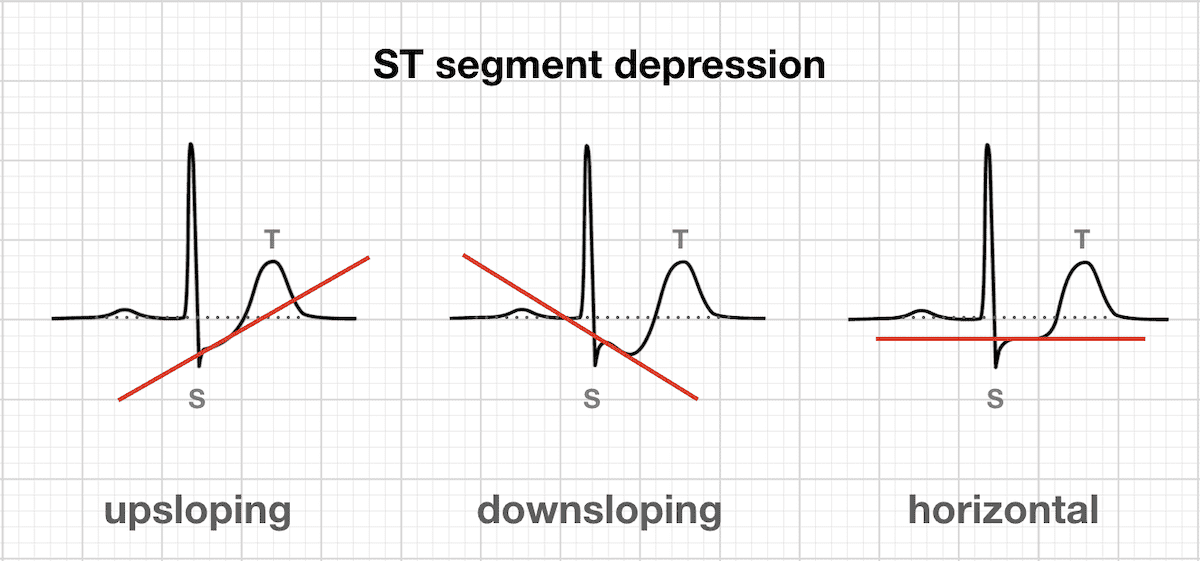

In [224]:
encoding_stslope = {"Up": 2, "Flat": 1, "Down": 0}
data["ST_Slope"] = data["ST_Slope"].apply(lambda slope: encoding_stslope[slope])

### **One hot encoding**


In [225]:
# One hot encoding for column ChestPainType
'''[TA: Typical Angina,
   ATA: Atypical Angina,
   NAP: Non-Anginal Pain,
   ASY: Asymptomatic]'''

encoded_pain = pd.get_dummies(data.ChestPainType).astype(int)
data = data.join(encoded_pain)
data = data.drop(columns=["ChestPainType"])

In [226]:
# One hot encoding for column RestingECG
'''[Normal: Normal,
        ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV),
       LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]'''

encoded_resting = pd.get_dummies(data.RestingECG).astype(int)
data = data.join(encoded_resting)
data = data.drop(columns=["RestingECG"])

## **Preliminary visualization**

Firstly, the visualization using pairplot provides a powerful way to explore relationships between selected features, with color coding to distinguish patients with (*label 1*) and without heart disease (*label 0*). By analyzing these plots, we can visually uncover patterns, trends, or potential correlations that may be valuable for our predictive modeling.

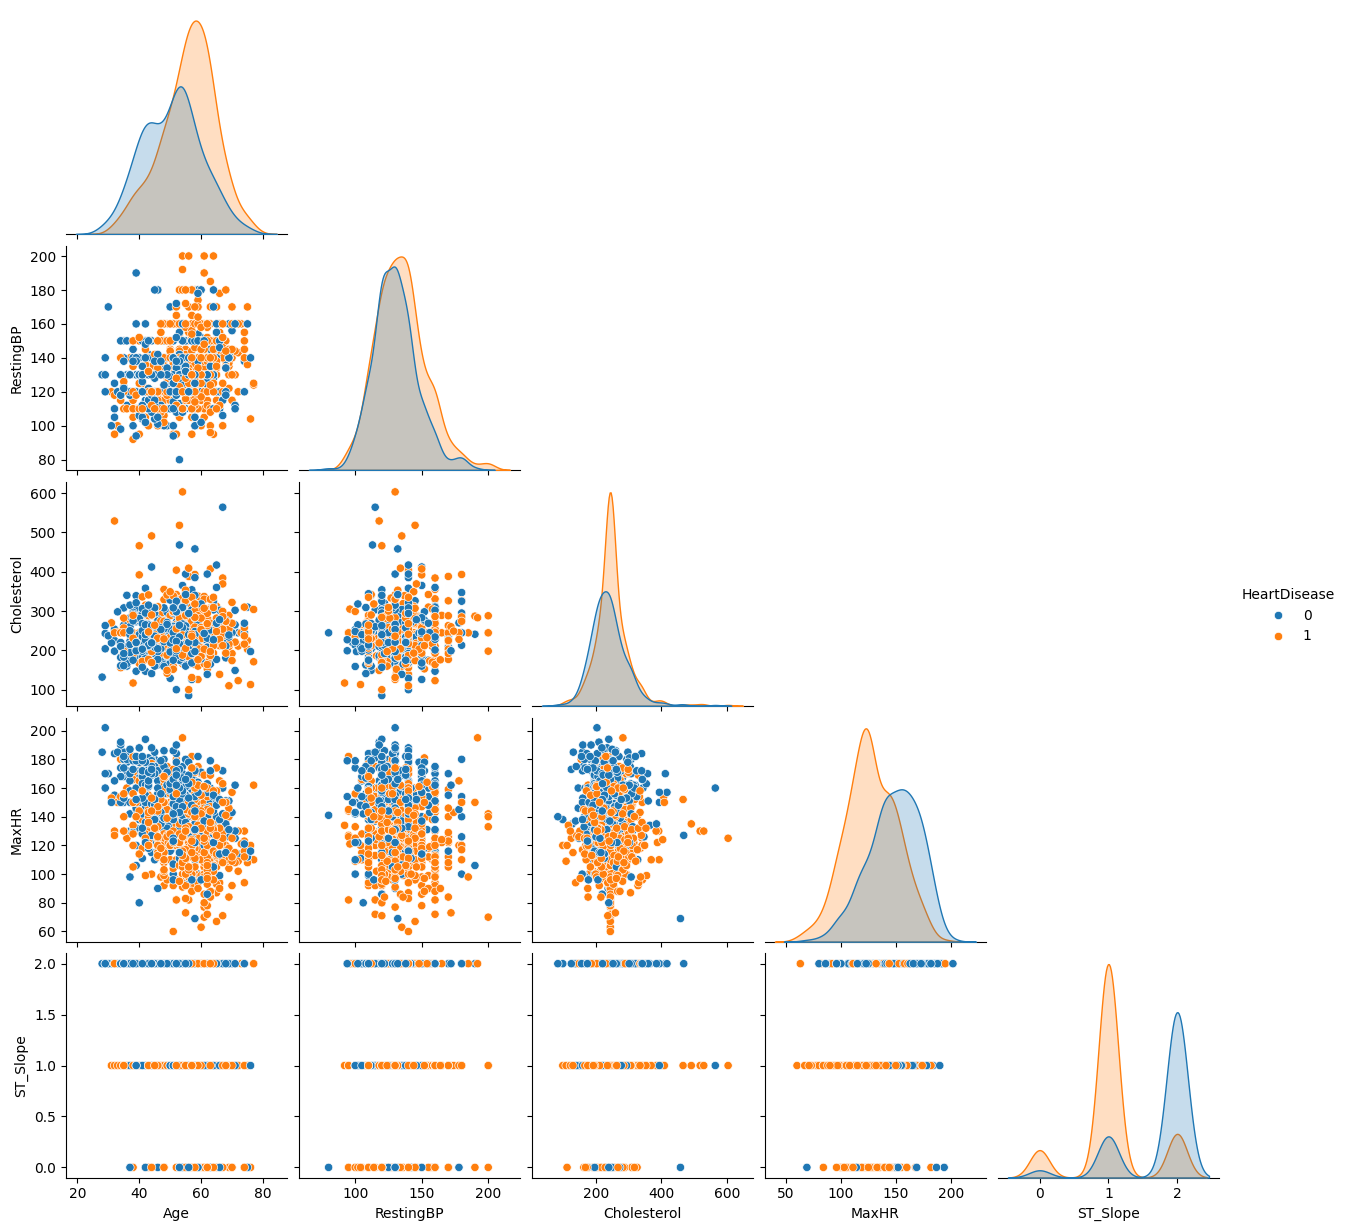

'As for label HeartDisease  [0: group of healthy people,\n                               1: group of people with heart disease problems]'

In [227]:
# List of relevant columns to include in the pairplot
relevant_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'ST_Slope', 'HeartDisease']
reduced_data = data[relevant_columns]

sns.pairplot(reduced_data, hue="HeartDisease", diag_kind="kde", corner=True)
plt.show()

'''As for label HeartDisease  [0: group of healthy people,
                               1: group of people with heart disease problems]'''

**Correlation matrix**

Next, we can take a closer look at the correlation matrix, which provides insights into the relationships between numerical features in our dataset. This matrix displays the Pearson correlation coefficient for each pair of variables, helping us understand their linear dependencies.

The Pearson correlation ranges from -1 to 1, with the following interpretations:

* 1 → Perfect positive correlation: As one variable increases, the other increases proportionally.
* -1 → Perfect negative correlation: As one variable increases, the other decreases proportionally.
*  0 → No linear correlation between the variables.

By analyzing these relationships, we can identify potential feature interactions and dependencies, guiding us in feature selection and model building.

In [228]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ASY,ATA,NAP,TA,LVH,Normal,ST
Age,1.000000,0.055750,0.263081,0.053373,0.198039,-0.382045,0.215793,0.258612,-0.268264,0.282039,0.166607,-0.218165,-0.011335,0.032042,0.145727,-0.230566,0.136798
Sex,0.055750,1.000000,0.009425,-0.101706,0.120076,-0.189186,0.190664,0.105734,-0.150693,0.305445,0.183876,-0.161522,-0.066486,-0.004031,-0.049518,-0.010634,0.063715
RestingBP,0.263081,0.009425,1.000000,0.083076,0.067811,-0.109662,0.153008,0.174220,-0.082139,0.117938,0.041541,-0.051367,-0.027483,0.049463,0.050641,-0.113718,0.089145
Cholesterol,0.053373,-0.101706,0.083076,1.000000,0.043008,-0.017239,0.077549,0.053029,-0.069723,0.094071,0.084533,-0.015288,-0.062229,-0.047322,0.075485,-0.042407,-0.024530
FastingBS,0.198039,0.120076,0.067811,0.043008,1.000000,-0.131438,0.060451,0.052698,-0.175774,0.267291,0.131176,-0.140514,-0.039249,0.026885,-0.011656,-0.093028,0.127110
MaxHR,-0.382045,-0.189186,-0.109662,-0.017239,-0.131438,1.000000,-0.370425,-0.160691,0.343419,-0.400421,-0.354963,0.253735,0.134580,0.100025,0.125793,0.023801,-0.157879
ExerciseAngina,0.215793,0.190664,0.153008,0.077549,0.060451,-0.370425,1.000000,0.408752,-0.428706,0.494282,0.430034,-0.300365,-0.166030,-0.128105,-0.016382,-0.072924,0.107036
Oldpeak,0.258612,0.105734,0.174220,0.053029,0.052698,-0.160691,0.408752,1.000000,-0.501921,0.403951,0.280026,-0.262124,-0.106212,0.032231,0.086794,-0.116719,0.055958
ST_Slope,-0.268264,-0.150693,-0.082139,-0.069723,-0.175774,0.343419,-0.428706,-0.501921,1.000000,-0.558771,-0.336411,0.332542,0.093376,-0.005235,-0.048901,0.089347,-0.060739
HeartDisease,0.282039,0.305445,0.117938,0.094071,0.267291,-0.400421,0.494282,0.403951,-0.558771,1.000000,0.516716,-0.401924,-0.212964,-0.054790,0.010670,-0.091580,0.102527


**Feature Selection Based on Correlation**

Below code is executed only if the *Feature_selection* variable is set to True. The purpose is to reduce the number of features used in the model by selecting only those that show a certain level of correlation with the target variable HeartDisease.

In [229]:
if Feature_selection:
    # Select features based on their absolute correlation with the target variable (HeartDisease) and compare them against the defined threshold
    filter = abs(corr["HeartDisease"]) > Correlation_threshold
    filter = pd.DataFrame(filter)

    # Select only features that meet the correlation threshold
    relevant_columns = list(filter[filter["HeartDisease"] == True].index)
    data = data[relevant_columns]

## **Scaling & splitting data**

In [230]:
# Defining the target variable (HeartDisease) = the outcome we aim to predict in our analysis
y = data["HeartDisease"]

# Define the feature set (X) = the remaining columns, which serve as input variables for the model
X = data.drop(columns=["HeartDisease"])

At this step, we need to ensure that all features in the dataset are scaled (or normalized) to a common range between 0 and 1, preventing features with larger ranges from dominating the model's learning process. For this, we utilize *MinMaxScaler()*.

In [231]:
# Normalizing (scaling) all features to a consistent scale ranging between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

Splitting the dataset is a key step in machine learning, ensuring the model is trained and evaluated properly.  

The dataset is divided into two parts:  
* **Training Set (80%)**: The larger portion of the data, used for learning patterns and relationships.  
* **Testing Set (20%)**: A smaller portion, reserved for evaluating how well the trained model generalizes to new, unseen data.  

This 80:20 split helps assess the model's performance while preventing overfitting. Moreover, the argument *stratify* ensures both sets are representative of the class distribution,  which is crucial for imbalanced datasets.  

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# **Building predictive models**

**Model configuration setup:**

We will make use of multiple machine learning models. Each model requires a different import and has its own set of hyperparameters.  
We store each model along with its corresponding hyperparameters in a dictionary for easy access and tuning. This structured approach allows for efficient hyperparameter tuning and sets as goal to find the best performing model on the dataset.



In [233]:
# Storing different ML models along with their respective hyperparameters in a dictionary
models = {
    "KNN": {"model": KNeighborsClassifier(), "parametry":{'n_neighbors':(3, 5, 7, 9), 'weights':["uniform", "distance"]}},
    "DT": {"model": DecisionTreeClassifier(), "parametry":{'splitter':("best", "random"), 'max_features':(None, "sqrt"), 'criterion':["gini", "entropy"]}},
    "LR": {"model": LogisticRegression(), "parametry":{'penalty':(None, "l1", "l2"), 'C':(0.1, 1, 10), 'solver':["liblinear", "lbfgs"]}},
    "RF": {"model": RandomForestClassifier(), "parametry":{'n_estimators':(50, 100, 200)}},
    "AB": {"model": AdaBoostClassifier(), "parametry":{'n_estimators':(50, 100, 200)}},
    "LSVM": {"model": LinearSVC(), "parametry":{'C':(0.1, 1, 10)}},
    "SVM": {"model": SVC(), "parametry":{'C':(0.1, 1, 10), "kernel" : ("poly", "rbf"), "gamma": ("scale", "auto")}},
    "NC" : {"model":NearestCentroid(), "parametry":{'metric' : ("euclidean", "manhattan")}}
}

In [234]:
# List for saving the list of results and best models
results = []
best_models = {}

# Loop for all models in the dictionary
for model, nastaveni in models.items():
  print(f"Processing model {model} ...")
  gs = GridSearchCV(nastaveni["model"], nastaveni["parametry"], cv=2)
  gs.fit(X_train, y_train)

  # after training using grid search we select the best combination of parameters for the given model
  # and save the best model
  best_model = gs.best_estimator_

  # Saving the best models for future use & reporting
  best_models[model] = best_model

  # Prediction on testing set
  y_pred = best_model.predict(X_test)

  # Recording the results for each model
  results.append({"metric": "F1", "model": model, "value": f1_score(y_test, y_pred)})
  results.append({"metric": "AUC", "model": model, "value": roc_auc_score(y_test, y_pred)})
  results.append({"metric": "Recall", "model": model, "value": recall_score(y_test, y_pred)})

Processing model KNN ...
Processing model DT ...
Processing model LR ...
Processing model RF ...
Processing model AB ...
Processing model LSVM ...
Processing model SVM ...
Processing model NC ...


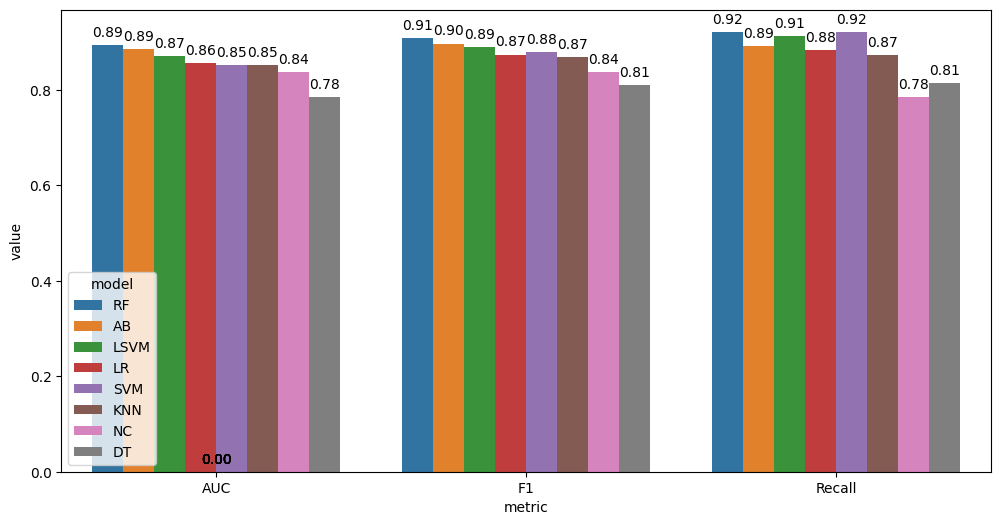

In [235]:
# Processing the collected results list into a pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# Sorting the DataFrame by value within each metric for plotting
results_df = results_df.sort_values(by=['metric', 'value'], ascending=[True, False])

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='metric', y='value', hue='model', data=results_df)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.2f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center',
        va = 'center',
        xytext = (0, 9),
        textcoords = 'offset points'
    )

plt.show()

In [236]:
best_models

{'KNN': KNeighborsClassifier(n_neighbors=9),
 'DT': DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        splitter='random'),
 'LR': LogisticRegression(C=1, penalty='l1', solver='liblinear'),
 'RF': RandomForestClassifier(n_estimators=200),
 'AB': AdaBoostClassifier(),
 'LSVM': LinearSVC(C=1),
 'SVM': SVC(C=10, gamma='auto'),
 'NC': NearestCentroid(metric='manhattan')}

We can also examine feature importance using the trained **Logistic Regression** model by analyzing its **coefficients (or weights)**. These values indicate the extent to which each feature impacts the model's predictions.

*  A **positive coefficient** implies a positive correlation with the target variable (HeartDisease), meaning that as the feature value increases, the likelihood of heart disease also increases.
*  A **negative coefficient** indicates a negative correlation, where a higher feature value reduces the likelihood of heart disease.

Since both positive and negative coefficients provide valuable insights, we take the absolute values and sort them in descending order to identify the most influential features.

In [237]:
# Higher absolute coefficient values indicate a greater predictive power of the respective feature
abs(pd.DataFrame(best_models['LR'].coef_, columns=X.columns)).T.sort_values(0, ascending=False)

,0
ST_Slope,3.63
ASY,1.65
Sex,1.26
FastingBS,1.16
MaxHR,1.08
ExerciseAngina,1.04
Oldpeak,0.85
Age,0.39
Cholesterol,0.24
ATA,0.14


When we examine the feature importance in our Logistic Regression model, *ST_Slope* emerges as the most influential predictor of HeartDisease. This underscores the significance of the ST segment's slope — representing the tilting of the ECG curve in the S and T segments (as illustrated earlier) — in assessing a person's likelihood of having heart disease.

Additionally, *ASY* (asymptomatic chest pain, where individuals experience heart-related issues without obvious symptoms) and *Sex* also play substantial roles in the model’s predictions. Their strong contribution suggests that both silent cardiac symptoms and biological differences are key factors in determining heart diseas

## **Comparison with Lazy Predict**

In [238]:
# Initialization of Lazy Predict
LP = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
LP_models, predictions = LP.fit(X_train, X_test, y_train, y_test)

 97%|█████████▋| 31/32 [00:05<00:00,  4.36it/s]

[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Info] Start training from score 0.213340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

100%|██████████| 32/32 [00:05<00:00,  5.77it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [239]:
LP_models
# Results of Lazy Predict:

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.90,0.90,0.90,0.90,0.70
RandomForestClassifier,0.89,0.89,0.89,0.89,0.65
AdaBoostClassifier,0.89,0.89,0.89,0.89,0.49
KNeighborsClassifier,0.88,0.87,0.87,0.87,0.08
NuSVC,0.88,0.87,0.87,0.87,0.12
LinearSVC,0.88,0.87,0.87,0.87,0.05
CalibratedClassifierCV,0.87,0.86,0.86,0.87,0.10
LogisticRegression,0.87,0.86,0.86,0.87,0.08
SVC,0.87,0.86,0.86,0.87,0.16


In [240]:
# Based on the results of modeling and Lazy Predict, we may choose the most effective model for further analysis
selected_model = "RF"

In [241]:
y_pred_selected = best_models[selected_model].predict(X_test)

We can calculate the confusion matrix for the best model's predictions on the test set. The visualziatin provides an intuitive and informative graphical representation of the model's performance regarding true/false positive and negative classifications, in order to assess the performance of a classification model.

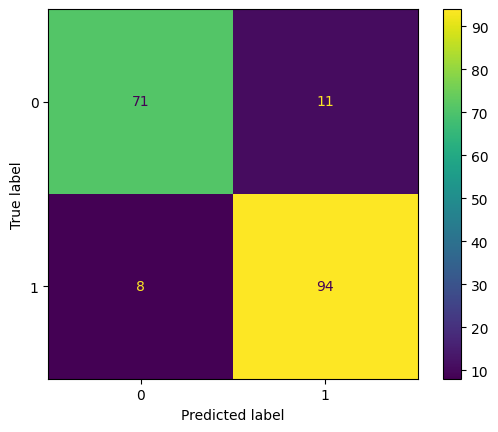

In [242]:
# Confusion Matrix for prediction of our selected model
cm = confusion_matrix(y_test,y_pred_selected)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The confusion matrix provides a comprehensive evaluation of the classification model's performance by categorizing its predictions into four key outcomes. These outcomes help us understand the model's strengths and weaknesses.

 **Correct Predictions:**
*  **True Positives** (TP = right bottom): accurately identified individuals with heart disease
*  **True Negatives** (TN = left top): accurately identified individuals without heart disease

**Prediction Errors:**
*  **False Positives** (FP = right top) - **Type I Error**: healthy individuals who were incorrectly classified as having heart disease, vernacularly called "false alarm"
*  **False Negatives** (FN = left bottom) - **Type II Error**: individuals with heart disease who were incorrectly classified as healthy, in other words "missed detection"


In the context of heart disease prediction, minimizing** Type II errors (False Negatives)** is of utmost importance. Failing to detect heart disease can have severe consequences for a patient's health and well-being.

Therefore, while maintaining overall accuracy is crucial, the primary focus should be on reducing false negatives. This can be achieved by adjusting the model's sensitivity to potential heart disease cases, even if it slightly increases the number of false positives."

## **Visualization of ROC Curve**

First, let's the necessary data for visualizing the model's performance through an ROC curve, specifically by obtaining the predicted probabilities for the positive class (HeartDisease) from our selected trained model, using the method *.predict_proba()*.

In [243]:
y_pred_selected_proba = pd.DataFrame(best_models[selected_model].predict_proba(X_test))[1]

To plot the **Receiver Operating Characteristic (ROC) curve** and evaluate the model's overall performance, we need to calculate the **False Positive Rate (FPR)** and **True Positive Rate (TPR)**. These metrics provide essential insights into the model's ability to distinguish between positive and negative cases.

In [244]:
FPR, TPR, thresholds = roc_curve(y_test, y_pred_selected_proba)

In [245]:
# Generating a baseline for comparison by simulating the performance of a random model
baseline_prob = [0 for _ in range(len(y_test))]
baseline_FPR, baseline_TPR, _ = roc_curve(y_test, baseline_prob)

Another key advantage of the ROC curve is that it allows us to visualize the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR). This allows us to predefine an acceptable false positive rate (*target_fpr*) and then visually determine the corresponding true positive rate the model achieves at that threshold.

In [246]:
target_FPR = 0.1

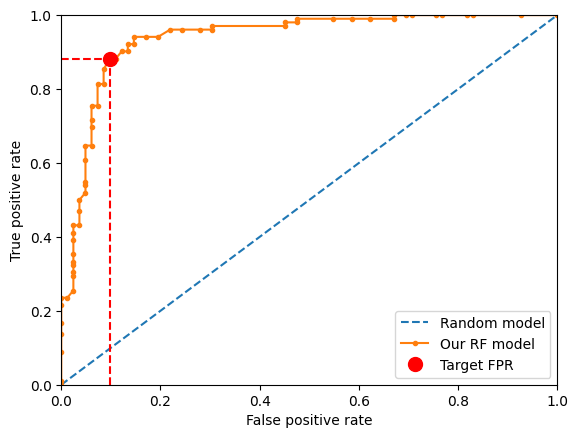

In [247]:
# Generating a plot comparing the performance of the AdaBoostClassifier model against a random model
plt.plot(baseline_FPR, baseline_TPR, linestyle='--', label='Random model')
plt.plot(FPR, TPR, marker='.', label=f"Our {selected_model} model")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Highlighting the point closest to our target FPR
closest_fpr_index = np.argmin(np.abs(FPR - target_FPR))
point_x = FPR[closest_fpr_index]
point_y = TPR[closest_fpr_index]

plt.plot(point_x, point_y, 'ro', markersize=10, label='Target FPR')  # Red circle representing target FPR
plt.vlines(point_x, 0, point_y, colors='red', linestyles='--')  # Vertical line
plt.hlines(point_y, 0, point_x, colors='red', linestyles='--')  # Horizontal line

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()


# **Conclusion**

This project explored the use of supervised learning, specifically regression techniques, to predict heart failure using the 'heart.csv' dataset from Kaggle. The process included data preprocessing tasks such as handling missing values and encoding categorical features, followed by preparing and comparing multiple models. Emphasizing the most relevant features helped reduce the model's complexity while improving accuracy.


The project was designed with flexibility in mind, enabling the adjustment of parameters like correlation thresholds and the use of toggle switches to control computationally intensive processes like Pandas Profiling. Lazy Predict was employed to provide a benchmark for our chosen models. The project's structure allows for the initial comparison of metrics such as AUC, F1, and recall across various models, empowering users to select the model best suited for further analysis. Additionally, when plotting the ROC curve, users can determine their acceptable false-positive rate and assess the corresponding accuracy for true positives.

**Key Findings and Observations:**

* **Patient attributes:** Age and Cholesterol were found to be less significant predictors of heart disease risk compared to factors such as the patient's sex, asymptomatic chest pain, and, most crucially, the slope of the ST segment. This highlights the importance of ST segment analysis in clinical assessments.
*  **Model performance:** Several models were evaluated, and RandomForest consistently emerged as the most effective model for predicting heart disease risk in this dataset. This suggests that RandomForest's ability to capture complex relationships within the data makes it well-suited for this application.

Although the regression models produced reasonable results, the dataset may not fully reflect the variety of real-world heart failure cases. Expanding the dataset with more diverse patient data could improve the model's generalizability and make it more applicable for future predictions.

